In [2]:
from IPython.display import HTML 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''') 

In [148]:
# to automatically import utils when it changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
from utils import *

In [157]:
data_folder = '../data/'
addresses_path = data_folder + 'addresses.csv'
active_addresses_path = data_folder + 'active_addresses.csv'
implicit_active_addresses_path = data_folder + 'implicit_active_addresses.csv'
clusters_path = data_folder + 'clusters.csv'

In [39]:
addresses = file_to_list(addresses_path)

## Find Active Addresses (not all received money) and clusters

In [45]:
active_addresses = set()
for i, address in enumerate(addresses):
    print(i, address, end='\r')
    if address not in active_addresses:
        n = get_address_n_transactions_in(address)
        if n:
            active_addresses.add(address)
list_to_file(active_addresses, active_addresses_path)

In [133]:
clusters = set()
for address in active_addresses:
    cluster = get_address_clusterID(address)
    clusters.add((cluster))
list_to_file(clusters, clusters_path)

In [134]:
print('Number of addresses in emails:', len(addresses))
print('Number of active addresses:', len(active_addresses))
print('Number of clusters:', len(clusters))

Number of addresses in emails: 12533
Number of active addresses: 247
Number of clusters: 98


In [137]:
coin = 'usd'
active_clusters_info_list = []
for c in clusters:
    info = get_cluster_info(c)
    if info:
        l = [info['noAddresses'], info['noOutgoingTxs'], info['noIncomingTxs'], info['totalSpent'][coin], info['totalReceived'][coin], info['firstTx']['timestamp'], c]
        active_clusters_info_list.append(l)

In [138]:
active_clusters_info_df = pd.DataFrame(active_clusters_info_list, columns=['n_addresses', 'n_txs_out','n_txs_in', 'spent', 'received', 'first_tx', 'cluster'])
active_clusters_info_df['first_tx_date'] = active_clusters_info_df.apply(lambda x: ts2date(x[-2]), axis=1)
active_clusters_info_df = active_clusters_info_df.sort_values('received', ascending=False)

### Exclude big/old clusters (exchanges or other services, probably) from our analysis

In [139]:
active_clusters_info_df.head()

,n_addresses,n_txs_out,n_txs_in,spent,received,first_tx,cluster,first_tx_date
43,430777,50134,2970697,2498276609,2579671809,1363978800,380319979,2013-03-22 20:00:00
38,618713,396711,1862307,2500058078,2500855343,1458573022,410460874,2016-03-21 16:10:22
2,52,7,410,240220,242891,1537890612,437552657,2018-09-25 17:50:12
1,25,8,506,200146,199548,1546863669,472568332,2019-01-07 13:21:09
61,22,13,299,178244,181226,1540932639,454492973,2018-10-30 21:50:39


In [140]:
bigOld_clusters = active_clusters_info_df.head(2).cluster.values # to ignore

In [141]:
kyc_addresses = set()
for a in active_addresses:
    c = get_address_clusterID(a)
    if c in bigOld_clusters:
        print(a, get_cluster_tags(c))
        kyc_addresses.add(a)

3QC1HbLXcqL7Uj4znrLmc8PmgvUHVRAcLG ['luno.com']
35H5cWjj61Tk8grVxtQsH3z5D6R6hNxRVA Unknown
398Qz1Autx6HJbJwvejXVhw4mXAmBW2KsW Unknown
3Jy5Ag9WYya7XD7aVwmRnpcrkehqnFhp5G Unknown


### Checking whether some of these addresses controlled by big old entities received victims' payments (sums between 200 and 1000)

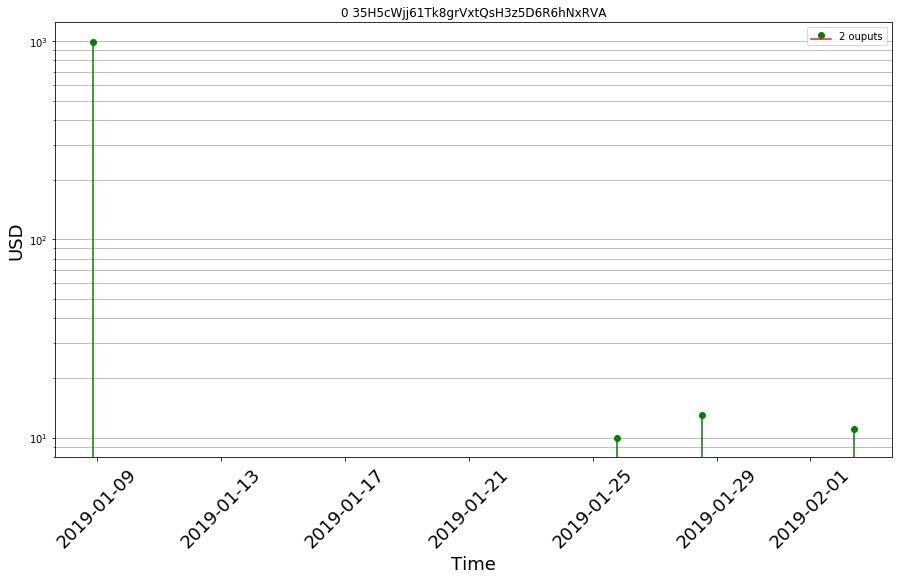

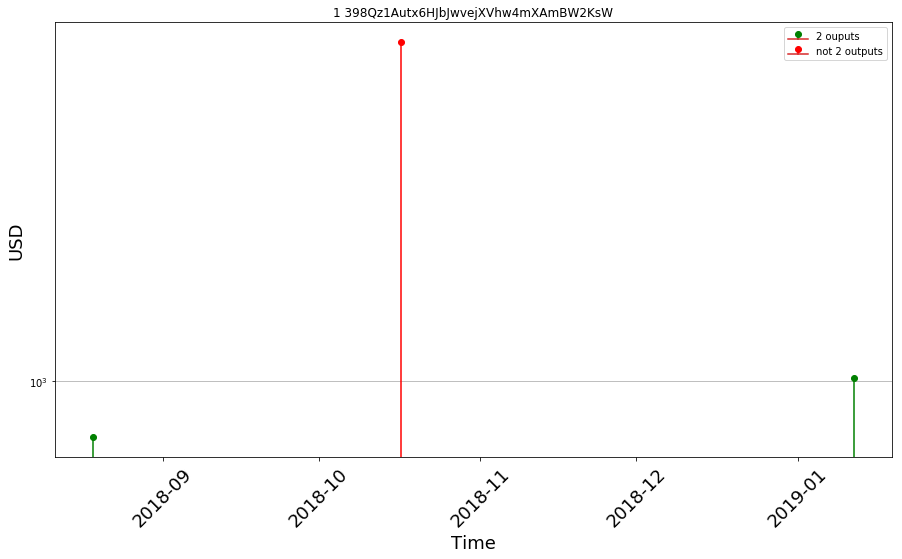

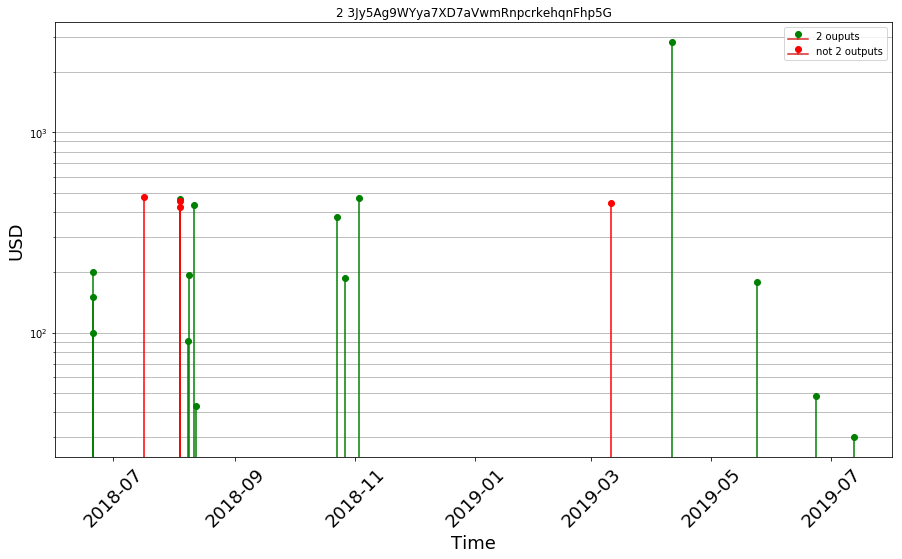

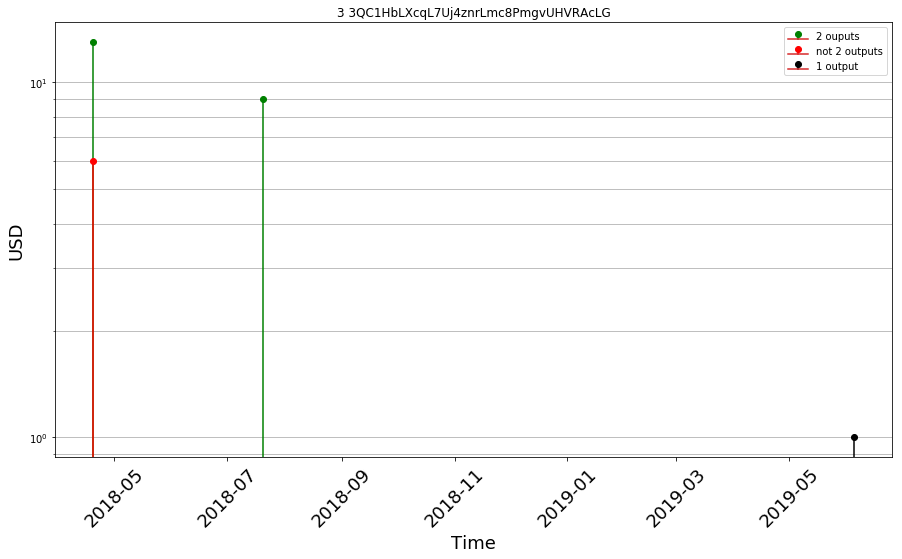

In [112]:
plot_addresses_txs_in_wrapper(kyc_addresses, address_type='explicit', min_n_txs=1)

### these addresses receive payments from victims
- 35H5cWjj61Tk8grVxtQsH3z5D6R6hNxRVA (tx example: 5df80b18298244fea14b15cf4d9346ba275d072e162bb178f885cdc06d962665)
- 398Qz1Autx6HJbJwvejXVhw4mXAmBW2KsW (tx example: cf841721d832832fc6c81ce546a86921fe0ff04a69ab825c591edea87a144516)
- 3Jy5Ag9WYya7XD7aVwmRnpcrkehqnFhp5G (tx example: 7c2298a475083741b3113b1f7eb281fa4bb2df063b65774219139c8a28530890)

### Additional addresses in clusters (expanded dataset)


In [155]:
implicit_active_addresses = set()
for i, cluster in enumerate(clusters):
    if cluster not in bigOld_clusters:
        ## if an address is in cluster, it is obviously also active 
        cas = get_cluster_addresses(cluster)
        for el in cas: 
            if el not in active_addresses:
                implicit_active_addresses.add(el)
implicit_active_addresses = list(implicit_active_addresses)
all_active_addresses = set(active_addresses).union(set(implicit_active_addresses))

In [158]:
list_to_file(implicit_active_addresses, implicit_active_addresses_path)

### Get flows of active addresses
TODO: run cell to retrieve flows of implicit active addresses

In [204]:
for n, a in enumerate(list(active_addresses)):
    print(n, end='\r')
    success = False
    while not success:
        try:
            hashes = get_address_txs_in(a)
            for hsh in hashes:
                f = get_payment_flow(a, hsh, max_steps=2, follow_address=a)    
            success = True
        except Exception as e:
            print(e)
            success = False

In [ ]:
# TODO: run cell
print(len(implicit_active_addresses))
for n, a in enumerate(list(implicit_active_addresses)):
    print(n, end='\r')
    success = False
    while not success:
        try:
            hashes = get_address_txs_in(a)
            for hsh in hashes:
                f = get_payment_flow(a, hsh, max_steps=2, follow_address=a)    
            success = True
        except Exception as e:
            print(e)
            success = False

### Transaction Filtering

In [185]:
# filter 1: remove txs with sextortion addresses among inputs
# filter 2: select txs with with proper range
# filter 3: remove txs with one output only


# assuming I already have all the flows from implicit and explicit addresses
n_methods = 3
meaningful_paths_list = [[] for i in range(n_methods)]
revenues_active_addresses = [0 for n in range(n_methods)]
btc_revenues_active_addresses = [0 for n in range(n_methods)]
coin = 'usd'

additional_addresses = set() # addresses sending maximum amount to sextortion addresses (btc does not change hands)

## for each available flow
for i, flow_path in enumerate(os.listdir(base_path)):
    print(i, end='\r')
    address, payment = flow_path.split('_')
    payment = payment.split('.')[0]
    success = False
    tx = None
    
    ## get details of payment
    while not success and not tx:
        try:
            tx = get_tx(payment)
            success = True
        except:
            print(payment)
    skip = False
    
    ## discard if input address is a sextortion address
    for i in tx['inputs']:
        if i['address'] in all_active_addresses:
            skip = True
            break

    if not skip:
        for out in tx['outputs']:
            if out['address'] == address:
                meaningful_paths_list[0].append(flow_path)
                val = out['value'][coin]
                val_btc = out['value']['satoshi']
                revenues_active_addresses[0] += val # first
                btc_revenues_active_addresses[0] += val_btc
                if val > 180 and val < 7700: # filter 1
                    revenues_active_addresses[1] += val # second
                    btc_revenues_active_addresses[1] += val_btc
                    meaningful_paths_list[1].append(flow_path)
                    if len(tx['outputs']) != 1: # filter 2
                        for el in tx['inputs']:
                            additional_addresses.add(el['address'])
                        meaningful_paths_list[2].append(flow_path) # third
                        revenues_active_addresses[2] += val
                        btc_revenues_active_addresses[2] += val_btc
                break # we don't care about other outputs cause we will get in other iterations with the proper sextortion address



### Payments and cumulative revenues
TODO: run cell to include also implicit active addresses

In [186]:
# this might take some time
t1 = get_addresses_txs(active_addresses, direction='in')


In [ ]:
# TODO: run cell
t2 = get_addresses_txs(implicit_active_addresses, direction='in')
t1.update(t2)

In [187]:
n_methods = 3
meaningful_txs_list = [set() for i in range(n_methods)]
for m in range(n_methods):
    for el in meaningful_paths_list[m]:
        addr, tx = el.split('_')
        tx = tx.split('.')[0]
        meaningful_txs_list[m].add(tx)

In [188]:
usd_th_max = 7700
usd_th_min = 180
n_methods = 3
# get all the possible payments
time_value_hash_address = [[] for i in range(n_methods)]
for a in t1: # all sextortion addresses
    for tx in t1[a]: # all received payments
#         print(a, tx['txHash'])
        value = 0
        for out in tx['outputs']: # look for current address among outputs
            if out['address'] == a:
                value += out['value'][coin]
        for m in range(n_methods):
            if tx['txHash'] in meaningful_txs_list[m]:
                time_value_hash_address[m].append([tx['timestamp'], value, tx['txHash'], a])
for m in range(n_methods):
    time_value_hash_address[m].sort(key=lambda x: x[0])
## by looking at the amount received and the timestamp, we could spot campaigns more easily, maybe

In [202]:
def plot_payments(data):
    fs = 24
    fig, ax1 = plt.subplots(1,1,figsize=(15,8))
    np_dates = [np.datetime64(datetime.datetime.utcfromtimestamp(el[0])) for el in data[1]] # filter 1+2
    np_dates1 = [np.datetime64(datetime.datetime.utcfromtimestamp(el[0])) for el in data[2]] # filter 1+2+3
#     np_dates2 = [np.datetime64(datetime.datetime.utcfromtimestamp(el[0])) for el in data[2]]
    np_dates_impl = [np.datetime64(datetime.datetime.utcfromtimestamp(el[0])) for el in data[0] if el[3] in implicit_active_addresses]
    # np_dates_nonGiant = [np.datetime64(datetime.datetime.utcfromtimestamp(el[0])) for el in data[1] if el[3] in non_giant_addresses]
    datemin = np.datetime64(np_dates[0], 'Y')
    datemax = np.datetime64(np_dates[-1], 'Y') + np.timedelta64(1, 'Y')
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    values = [el[1] for el in data[1]]
    values1 = [el[1] for el in data[1] if el[3] in implicit_active_addresses]
#     values1 = [el[1] for el in data[1] if el[3] in non_giant_addresses]
    print(len(values1))
    print(len(values))
    ax1.scatter(np_dates, values, s=10, color='g', label='Payments to Seed Addresses')
#     ax1.scatter(np_dates, values, s=10, color='g', label='Payments to Main Component')
    ax1.scatter(np_dates_impl, values1, s=10, color='b', label='Payments to Expanded Addresses')
    # ax1.scatter(np_dates_nonGiant, values1, s=10, color='b', label='Payments not to Main Component')
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylabel('USD (Payments)', fontsize=fs)
    plt.legend(loc=2, fontsize=fs)
#     plt.yscale(value='log')
#     plt.xlabel('Time', fontsize=fs)
    plt.xticks(fontsize=fs, rotation=20)
    plt.yticks(fontsize=fs)

    ax2 = ax1.twinx()
    cumsums = []
    for m in range(n_methods):
        cumsums.append(np.array([el[1] for el in data[m]]).cumsum().tolist())
#     ax2.step(np_dates, cumsums[0], '-', where='post', label='Revenues Filter 1', color='y', linewidth=3)
    ax2.step(np_dates, cumsums[1], '--', where='post', label='Revenues Filter 1+2', color='b', linewidth=3)
    ax2.step(np_dates1, cumsums[2], ':', where='post', label='Revenues Filter 1+2+3', color='g', linewidth=3)
    plt.yticks(fontsize=fs)
    ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#     plt.yscale(value='log')
    plt.ylabel('USD (Cumulative)', fontsize=fs)
    plt.tight_layout()
    plt.legend(loc=6, fontsize=fs)
#     plt.savefig('../images/payments_scatter.pdf')
    plt.show()
    return values

0
1444


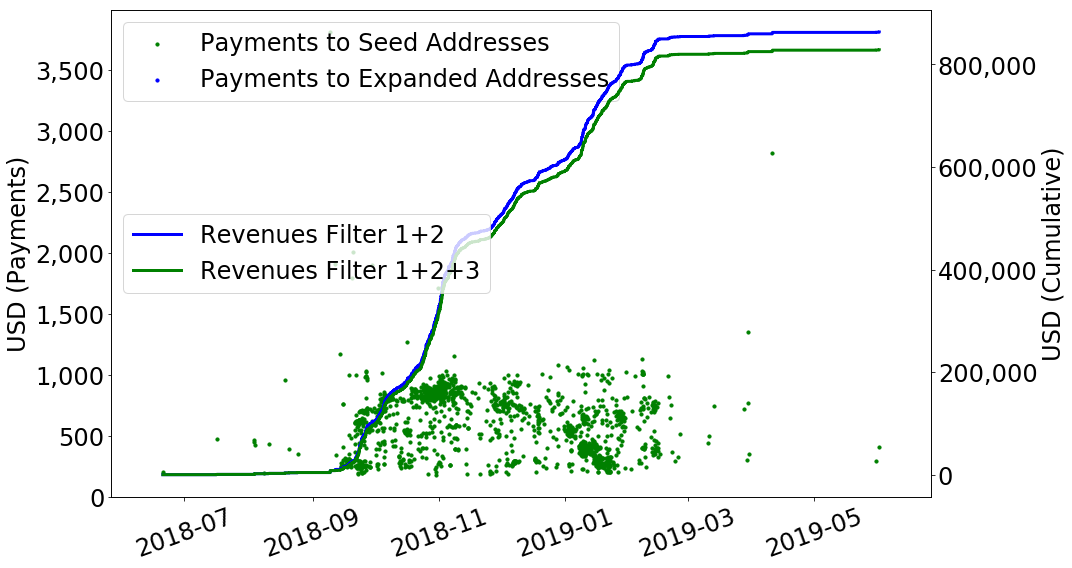

In [203]:
values = plot_payments(time_value_hash_address)